In [1]:
import obspy
import obspy.signal
from obspy import read
from obspy.imaging.spectrogram import spectrogram
from obspy.signal.cross_correlation import correlate,xcorr_max
from IPython.display import display, Markdown
import numpy as np
import copy
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
st=read("2011-03-11-mw91-near-east-coast-of-honshu-japan-2.miniseed")
st

6 Trace(s) in Stream:
IU.PAB.00.BH1 | 2011-03-11T05:59:50.019536Z - 2011-03-11T07:59:49.969536Z | 20.0 Hz, 144000 samples
IU.PAB.00.BH2 | 2011-03-11T05:59:50.019538Z - 2011-03-11T07:59:49.969538Z | 20.0 Hz, 144000 samples
IU.PAB.00.BHZ | 2011-03-11T05:59:50.019538Z - 2011-03-11T07:59:49.969538Z | 20.0 Hz, 144000 samples
IU.PAB.10.BH1 | 2011-03-11T05:59:50.019536Z - 2011-03-11T07:59:49.994536Z | 40.0 Hz, 288000 samples
IU.PAB.10.BH2 | 2011-03-11T05:59:50.019538Z - 2011-03-11T07:59:49.994538Z | 40.0 Hz, 288000 samples
IU.PAB.10.BHZ | 2011-03-11T05:59:50.019536Z - 2011-03-11T07:59:49.994536Z | 40.0 Hz, 288000 samples

### Plot seismogram + interractive spectrogram; <br> right-click mouse to pick arrivals on spectrogram

In [3]:
# setup the function for interactive picking by right-click on the graphic: 
def onclick(event):
    if event.button == 3: 
        pos.append([event.xdata,event.ydata])
        plt.text(event.xdata, event.ydata, 'o', color='r',weight='bold',\
        horizontalalignment='center',verticalalignment='center')
        print([event.xdata,event.ydata])

<IPython.core.display.Javascript object>


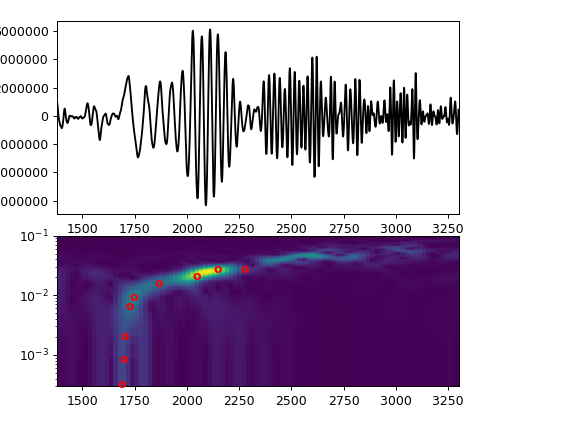

In [6]:
i=1;pos=[]
fig = plt.figure();
ax1 = fig.add_axes([0.1, 0.5, 0.7, 0.45]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.35], sharex=ax1)
t = np.arange(st[i].stats.npts) / st[i].stats.sampling_rate
tstart=st[i].stats.starttime
ax1.plot(t, st[i].data, 'k')
st[i].spectrogram(show=True, axes=ax2,log=True,wlen=200)
ax2.set_ylim(0.0003,.1)
ax1.set_xlim(23*60,55*60)
cid=fig.canvas.mpl_connect('button_press_event', onclick)

### Use picked values to : <br> 1) Estimate apparent velocities as Distance / Traveltime for each frequency <br> 2) Make a crude estimate of depth-velocity profile
$$
z\approx \frac{1}{4}\ \frac{c(f)}{f}
$$
where $c$ is velocity and $f$ is frequency

In [7]:
fig.canvas.mpl_disconnect(cid)
# sort the "picks" by increasing frequencies:
###############################################
def TakeFirst(elem):
    return elem[1]
posa=sorted(pos,key=TakeFirst)
posa=np.asarray(posa)
freqs=posa[:,1];# (store the frequencies in vector freq)
# Picked time is only relative to P arrival.
# Need to add Tp and an offset To to obtain the "absolute" arrival time:
#####################################################################
Tp=13*60+27;To=2*60;dist=96*111;
tarr=posa[:,0]+Tp-To;
# Compute velocity vector as (distance)/(arrival time):
#######################################################
vels=dist/tarr;#
# Crude estimate of depth-velocity distribution.
# This uses the thumb rule depth = (1/4)*c/f where c is velocity:
deps=np.multiply(vels,.25/freqs)

### Graph the dispersions curve obtained <br> Graph the indicative depth-velocity profile

<IPython.core.display.Javascript object>


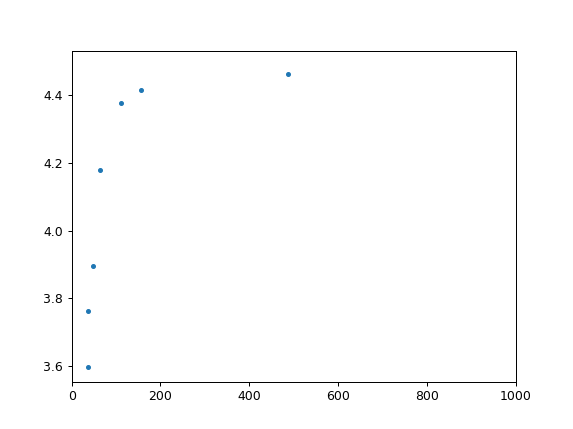

<IPython.core.display.Javascript object>


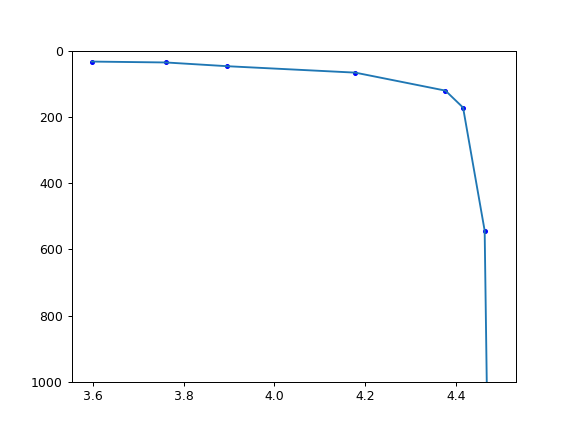

In [8]:
#%matplotlib notebook
#import matplotlib
#import matplotlib.pyplot as plt
fig3,ax3=plt.subplots()
ax3.plot(1/freqs,vels,'.');ax3.set_xlim(0,1000)
fig4,ax4=plt.subplots()
ax4.plot(vels,deps,'.b');ax4.plot(vels,deps);
ax4.set_ylim(0,1000);ax4.invert_yaxis()

### Compute the theoretical dispersion curve for a layer over a half space
The velocity $c$ for a given angular frequency $\omega=2\pi f$ is obtained by
solving the equation:
$$
\tan \omega\, H \sqrt{\beta_1^{-2}-c^{-2}} = 
\frac{\mu_2}{\mu_1}\frac{\sqrt{c^{-2}-\beta_2^{-2}}}{\sqrt{\beta_1^{-2}-c^{-2}}}
$$
where: <br>
$H$ is thickness of top layer,<br>
$\beta_1$ and $\beta_2$ are shear wave velocities in top layer and half-space, <br>
$\mu_1$ and $\mu_2$ are shear moduli in top layer and half-space. 

Here a value of $c$ is sought which minimizes the difference defined as :
$$
\textrm{diff}(c)=\tan \omega\, H \sqrt{\beta_1^{-2}-c^{-2}} - 
\frac{\mu_2}{\mu_1}\frac{\sqrt{c^{-2}-\beta_2^{-2}}}{\sqrt{\beta_1^{-2}-c^{-2}}}
$$
To this purpose the python optimization routine __fsolve__ is used.

### Finally, the theoretical prediction (red) is plotted against the dispersion curve (blue) obtained from the spectrogram.


<IPython.core.display.Javascript object>


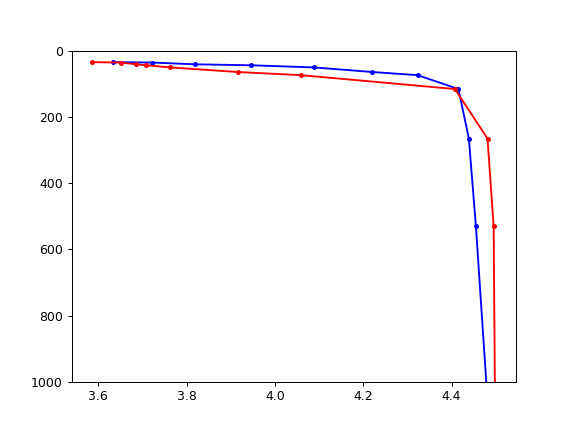

In [22]:
from scipy.optimize import fsolve

b1=3.55;H=43; # these are the values to be "inverted"
#
b2=4.5  # assume this "low freq" limit well constrained - keep fixed 
# assume this relation between density and velocity to reduce nr. of parameters:
# rho1=b1/1.4;rho2=b2/1.4; 
#
#mu1=rho1*b1**2;mu2=rho2*b2**2
#mur=mu2/mu1
mur=1.5

# define the difference function which needs to be minimised:
def diff(x):
    y = np.tan(w*H*np.sqrt((1/b1**2)-1/x**2) ) \
    - mur*np.sqrt(1/x**2-1/b2**2)/np.sqrt(1/b1**2-1/x**2)
    # Bounce off a very large value of misfit 
    # if velocity higher than fundamental mode.
    # This will avoid selection of other modes:
    if x > cmax: y=1e20 
    return y

# Find the minimum for each frequency value in a loop,
# store results in lists vv (velocities) and and ww (periods):
vv=[];ww=[];
for w in 2*3.1416*freqs:
    cmin=b1;cmax=b2;
    # cmax is maximum velocity for the FIRST mode in the solution
    # becasue tan has infinite solutions for each n*2*pi, we want only n=0. 
    if 1/b1**2 - (1/(2*w*H))**2 > 0:
        cmax=(   1/b1**2 - (1/(2*w*H))**2  )**(-1/2)
    if cmax < cmin: cmax=cmin
    c0 = fsolve(diff, 1.01*cmin)[0]
    vv.append(c0);ww.append(2*3.1416/w)
    
# Plot the theoretical and observed dispersion curves:
fig,ax=plt.subplots()
ax.plot(vels,1/freqs,'.b');ax.plot(vels,1/freqs,'b')
ax.plot(vv,ww,'.r');ax.plot(vv,ww,'r')
#ax.plot(vels,deps);
ax.set_ylim(0,1000)
ax.invert_yaxis()

In [118]:
print(mur)

2.479591836734694


In [59]:
from scipy.io.wavfile import write
data=st[1].data
scaled = np.int16(data/np.max(np.abs(data)) * 32767)
write('test1.wav', 44100, scaled)
from IPython.display import Audio
Audio(st[1].data, rate=.5e5,autoplay=False)

## To do: 
* Highlight trade-offs between two values in the misfit space. Fur example:
    + Keep fixed b2 and mur.
    + Explore a grid of possible values b1, H <br>
    + Compute the misfit for each pair (b1, H) <br>
    + Plot misifit on a (b1, H) diagram. 
* Use a gradient or other method to explore the parameter space